In [33]:
import pandas as pd
import re
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np


In [34]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

flight1 = pd.read_csv('eda_flights9.csv')
flight = flight1.copy()
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   flight_id          127 non-null    int64  
 1   departure_airport  127 non-null    object 
 2   arrival_airport    127 non-null    object 
 3   actual_departure   127 non-null    object 
 4   delay              127 non-null    float64
 5   profit             118 non-null    float64
 6   economy_percent    127 non-null    int64  
 7   business_percent   127 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 8.1+ KB


In [35]:
# функция для построения боксплотов по отношению к profit

def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='profit',
                data=flight.loc[flight.loc[:, column].isin(
                    flight.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

# Общий анализ данных

In [36]:
flight.head()

,flight_id,departure_airport,arrival_airport,actual_departure,delay,profit,economy_percent,business_percent
0,136119,AAQ,SVO,2017-01-03T10:08:00Z,3.0,1.446855e+06,86,91
1,136120,AAQ,SVO,2017-02-24T10:07:00Z,2.0,1.403337e+06,83,91
2,136122,AAQ,SVO,2017-01-08T10:08:00Z,3.0,1.226896e+06,73,83
3,136130,AAQ,SVO,2017-02-13T10:07:00Z,2.0,1.354537e+06,82,83
4,136131,AAQ,SVO,2017-01-28T10:07:00Z,2.0,1.610737e+06,94,100


Выведем строки с пустыми значениями в столбце profit и посмотрим, чем они отличаются от остальных.

In [37]:
flight[pd.isnull(flight.profit)]

,flight_id,departure_airport,arrival_airport,actual_departure,delay,profit,economy_percent,business_percent
59,136511,AAQ,NOZ,2017-02-21T06:15:00Z,5.0,NaN,0,0
60,136513,AAQ,NOZ,2017-02-28T06:13:00Z,3.0,NaN,0,0
61,136514,AAQ,NOZ,2017-02-07T06:14:00Z,4.0,NaN,0,0
62,136523,AAQ,NOZ,2017-01-10T06:14:00Z,4.0,NaN,0,0
63,136540,AAQ,NOZ,2017-01-17T06:14:00Z,4.0,NaN,0,0
64,136544,AAQ,NOZ,2017-01-31T06:10:00Z,0.0,NaN,0,0
65,136546,AAQ,NOZ,2017-01-03T06:13:00Z,3.0,NaN,0,0
66,136560,AAQ,NOZ,2017-01-24T06:13:00Z,3.0,NaN,0,0
67,136567,AAQ,NOZ,2017-02-14T06:12:00Z,2.0,NaN,0,0


Как мы видим, пропуски в столбце profit соответствуют пропускам в столбце tf_amount, где мы считаем стоимость всех проданных билетов. В остальном данные по этим рейсам удивительно похожи: пункт назначения, тип воздушного судна и приблизительно - время полета. Кажется, мы нашли регулярно повторяющийся пустой рейс. Сохраним эти строки в отдельный датасет, а из основного датасета их удалим.

In [38]:
without_passenger = flight[pd.isnull(flight.profit)]

flight = flight.dropna(subset=['profit'], axis=0)
flight.reset_index(drop=True, inplace=True)

Логика у меня следующая: поскольку рейс регулярный и все про него знают, значит, он в расписании зачем-то нужен. Поэтому не надо предлагать снять этот рейс и не надо заполнять пустые значения медианами или средними. Надо просто исключить эти рейсы из рассмотрения. Посмотрим, остались ли у нас рейсы в Новокузнецк?

In [39]:
flight[flight.arrival_airport.str.match("NOZ", na=False)]

,flight_id,departure_airport,arrival_airport,actual_departure,delay,profit,economy_percent,business_percent


Новокузнецк из рассмотрения выпал.

Со строками все понятно, посмотрим на колонки. 

In [40]:
flight.columns

Index(['flight_id', 'departure_airport', 'arrival_airport', 'actual_departure',
       'delay', 'profit', 'economy_percent', 'business_percent'],
      dtype='object')

Не хватает признаков, которые могут быть полезны потом. Добавим колонку с зашифрованными днями недели (0 - понедельник, 6 - воскресенье) и колонки с месяцем и с часом отбытия.

In [41]:
flight.actual_departure = pd.to_datetime(flight['actual_departure'])
flight['departure_day_of_week'] = flight['actual_departure'].dt.dayofweek
flight['departure_time'] = flight['actual_departure'].dt.hour
flight['departure_month'] = flight['actual_departure'].dt.month

In [42]:
flight['profit'] = round(flight['profit'])

count    1.180000e+02
mean     1.041207e+06
std      4.126718e+05
min      4.642740e+05
25%      6.796740e+05
50%      9.469020e+05
75%      1.423787e+06
max      1.681896e+06
Name: profit, dtype: float64

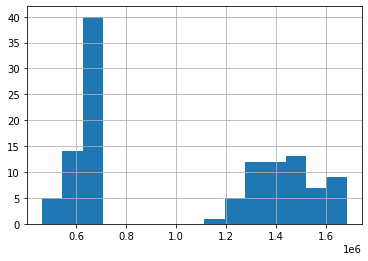

In [43]:
flight.profit.hist(bins=15)
flight.profit.describe()

Позднее мы проверим гипотезу, что это прибыль, сгруппированная по двум аэропортам.

In [44]:
flight_num_cols = ['delay', 'profit', 'economy_percent', 'business_percent']

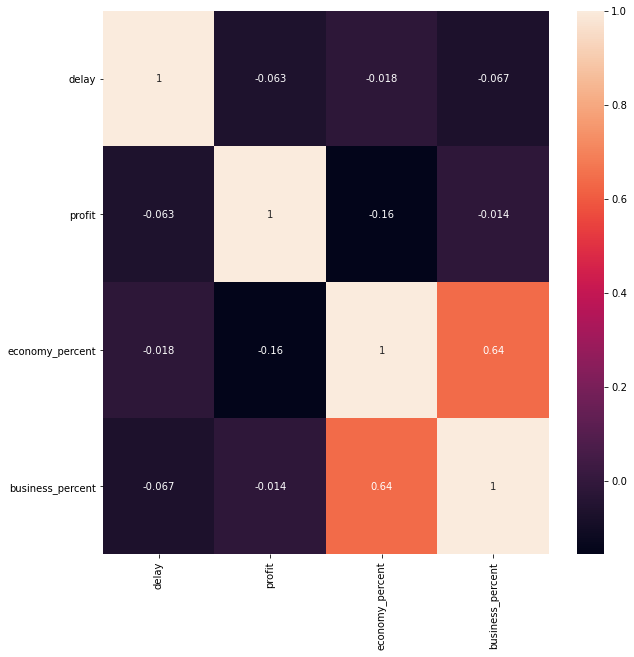

In [45]:
sns.heatmap(flight[flight_num_cols].corr(), annot=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)

По этой визуализации мы видим, что все колонки слабо коррелируют друг с другом и могут быть использованы в анализе. 

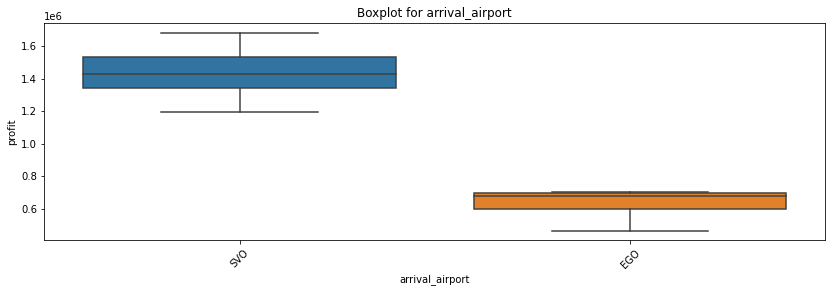

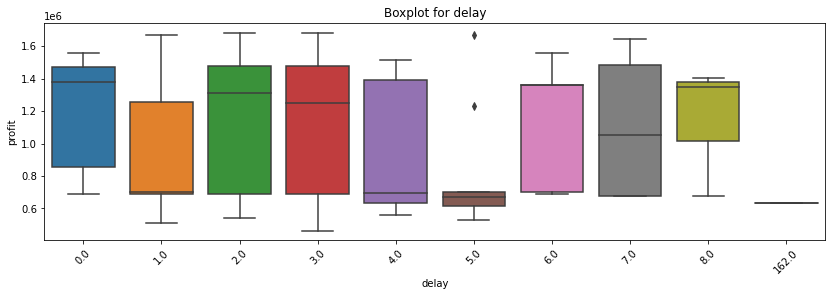

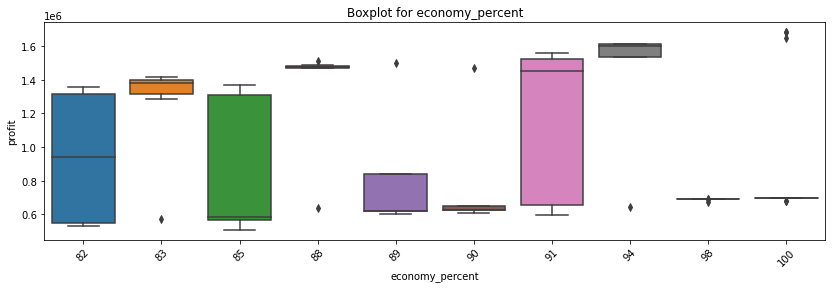

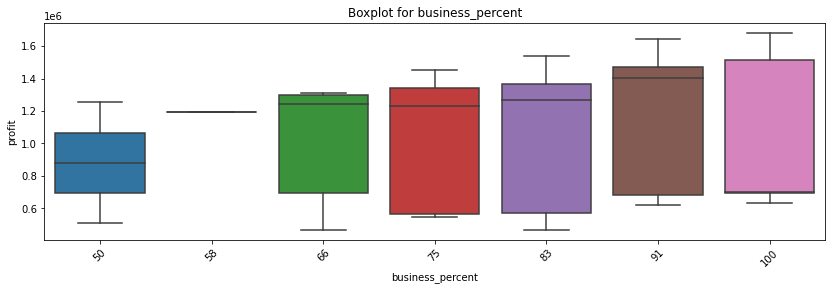

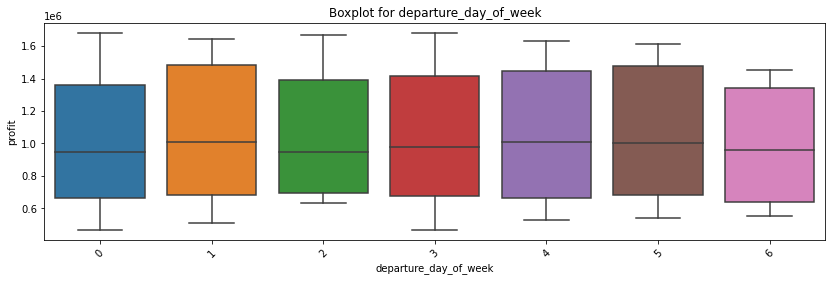

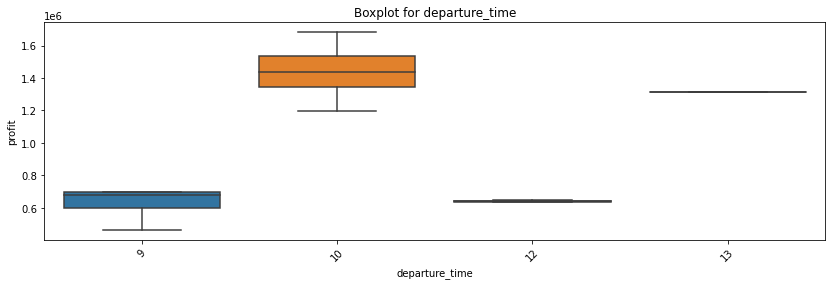

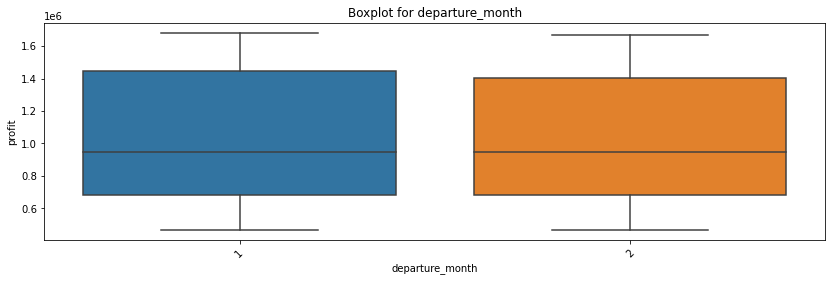

In [46]:
for col in ['arrival_airport', 'delay', 'economy_percent', 'business_percent', 'departure_day_of_week', 'departure_time', 'departure_month']:
    get_boxplot(col)

Что мы видим:

1. Рейсы в Белгород существенно менее прибыльные, чем в Москву, однако закрыть целое направление - это задача более глубокого исследования. Попробуем в дальнейшем сгруппировать рейсы по направлениям и посмотреть на каждое отдельно.
2. Среди опозданий есть аномальное значение - надо его проверить дополнительно.
3. Чаще всего рейсы задерживаются на 2-3 минуты. А прилетают чаще всего на те же 2-3 минуты позже. Мы подтвердили, что задержка и опоздание связаны, и их можно исключить из рассмотрения на первом этапе.
4. Надо внимательнее изучить связь между прибыльностью рейсов и днями недели, по которым они летают.
4. У нас есть два штатных времени отбытия: скорее всего, это время регулярного отбытия из обоих аэропортов.

# Исследование по направлениям

<AxesSubplot:xlabel='arrival_airport', ylabel='profit'>

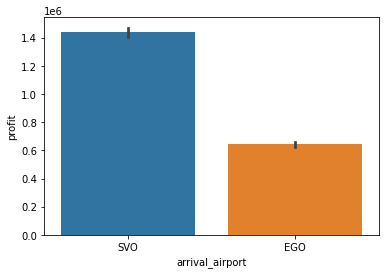

In [47]:
airport_profit = flight[['flight_id', 'arrival_airport', 'profit',
                         'departure_day_of_week', 'actual_departure', 'departure_time', 'economy_percent', 'business_percent']]
sns.barplot(x='arrival_airport', y='profit', data=airport_profit)

Мы видим, что в целом направление на Москву гораздо прибыльнее, чем на Белгород. Подсчитаем разницу между их средними значениями.

In [48]:
round(airport_profit[airport_profit.arrival_airport.str.match(
    "SVO", na=False)]['profit'].mean() - airport_profit[airport_profit.arrival_airport.str.match(
    "EGO", na=False)]['profit'].mean())

795222

Разница впечатляет. Однако закрывать целое направление - не задача нашего исследования. Но можно посмотреть на относительную прибыль, которую они приносят? Примем за примерную оценку идеальной прибыли случай, когда все места в самолете заполнены. Найдем эти рейсы среди московских, а затем получим идеальную прибыль для направления на Москву.

In [49]:
airport_profit.loc[(airport_profit['arrival_airport'] == 'SVO') & (
    airport_profit['economy_percent'] == 100) & (airport_profit['business_percent'] == 100)]

,flight_id,arrival_airport,profit,departure_day_of_week,actual_departure,departure_time,economy_percent,business_percent
19,136226,SVO,1681896.0,0,2017-01-30 10:08:00+00:00,10,100,100
32,136316,SVO,1681896.0,3,2017-01-12 10:07:00+00:00,10,100,100


In [58]:
ideal_profit_msk = round(airport_profit.loc[(airport_profit['arrival_airport'] == 'SVO') & (
    airport_profit['economy_percent'] == 100) & (airport_profit['business_percent'] == 100)]['profit'].mean())

print('Идеальная прибыль для московских рейсов равна', ideal_profit_msk)

Идеальная прибыль для московских рейсов равна 1681896


То же самое для Белгорода

In [52]:
airport_profit.loc[(airport_profit['arrival_airport'] == 'EGO') & (
    airport_profit['economy_percent'] == 100) & (airport_profit['business_percent'] == 100)]

,flight_id,arrival_airport,profit,departure_day_of_week,actual_departure,departure_time,economy_percent,business_percent
61,136600,EGO,698574.0,2,2017-02-08 09:26:00+00:00,9,100,100
62,136605,EGO,697239.0,2,2017-02-15 09:28:00+00:00,9,100,100
84,136755,EGO,698574.0,5,2017-01-21 09:30:00+00:00,9,100,100
85,136757,EGO,699908.0,4,2017-01-27 09:30:00+00:00,9,100,100
86,136758,EGO,699908.0,3,2017-01-12 09:26:00+00:00,9,100,100
91,136781,EGO,698574.0,5,2017-01-14 09:26:00+00:00,9,100,100
94,136815,EGO,697239.0,6,2017-02-19 09:26:00+00:00,9,100,100
97,136827,EGO,697239.0,5,2017-02-18 09:26:00+00:00,9,100,100
99,136841,EGO,697239.0,1,2017-02-07 09:25:00+00:00,9,100,100
102,136857,EGO,698574.0,0,2017-02-13 09:31:00+00:00,9,100,100


Таких гораздо больше

In [57]:
ideal_profit_blg = round(airport_profit.loc[(airport_profit['arrival_airport'] == 'EGO') & (
    airport_profit['economy_percent'] == 100) & (airport_profit['business_percent'] == 100)]['profit'].mean())

print('Идеальная прибыль для белгородских рейсов равна', ideal_profit_blg)

Идеальная прибыль для белгородских рейсов равна 698240


In [59]:
percent_profit_msk = round((airport_profit[airport_profit.arrival_airport.str.match(
    "SVO", na=False)]['profit'].mean()/ideal_profit_msk)*100)
print('Прибыльность направления на Москву - {}%'.format(percent_profit_msk))

Прибыльность направления на Москву - 86%


In [60]:
percent_profit_blg = round((airport_profit[airport_profit.arrival_airport.str.match(
    "EGO", na=False)]['profit'].mean()/ideal_profit_blg)*100)
print('Прибыльность направления на Белгород - {}%'.format(percent_profit_blg))

Прибыльность направления на Белгород - 92%


Так какое направление у нас более убыточное, а? :)

Вычислим рейсы с самой маленькой прибылью по обоим направлениям.

In [112]:
min_profit_SVO = airport_profit[airport_profit.arrival_airport.str.match(
    "SVO", na=False)]['profit'].min()
min_profit_EGO = airport_profit[airport_profit.arrival_airport.str.match(
    "EGO", na=False)]['profit'].min()

print('Самый убыточный рейс в Москву - ',
      flight.loc[flight.profit == min_profit_SVO][['flight_id', 'departure_day_of_week', 'profit']])
print('Самый убыточный рейс в Белгород - ',
      flight.loc[flight.profit == min_profit_EGO][['flight_id', 'departure_day_of_week', 'profit']])

Самый убыточный рейс в Москву -      flight_id  departure_day_of_week     profit
54     136464                      0  1193896.0
Самый убыточный рейс в Белгород -      flight_id  departure_day_of_week    profit
93     136807                      3  464274.0


In [113]:
airport_profit_sorted_SVO = airport_profit[airport_profit.arrival_airport.str.match(
    "SVO", na=False)].sort_values(['profit', 'departure_day_of_week'])
airport_profit_sorted_EGO = airport_profit[airport_profit.arrival_airport.str.match(
    "EGO", na=False)].sort_values(['profit', 'departure_day_of_week'])

## По дням недели

Проверим нашу гипотезу о "плохих" рейсах, проведя анализ заполненности рейса по дням недели и датам. Начнем с Москвы:

In [114]:
airport_profit_sorted_SVO.groupby('departure_day_of_week')[
    'economy_percent'].mean().sort_values(ascending=False)

departure_day_of_week
1    90.777778
4    89.000000
3    87.500000
5    87.125000
0    86.444444
2    85.500000
6    79.666667
Name: economy_percent, dtype: float64

In [115]:
airport_profit_sorted_SVO.groupby('departure_day_of_week')[
    'business_percent'].mean().sort_values(ascending=False)

departure_day_of_week
4    91.375000
5    90.125000
1    87.555556
3    86.125000
2    86.125000
6    85.666667
0    84.111111
Name: business_percent, dtype: float64

In [116]:
airport_profit_sorted_SVO.groupby(['departure_day_of_week'])[
    'profit'].mean().sort_values(ascending=False)

departure_day_of_week
1    1.502216e+06
4    1.491542e+06
5    1.463221e+06
3    1.446861e+06
0    1.421189e+06
2    1.416271e+06
6    1.337385e+06
Name: profit, dtype: float64

Мы видим, что наиболее популярный день для отлета в Москву в общем - это вторник. Бизнес-класс больше всего заполнен в пятницу и в субботу: закончив работу, деловые люди спешат домой. То есть рейсы во вторник, в пятницу и в субботу снимать не стоит.

Самые незагруженные и неприбыльные дни в разных комбинациях - это понедельник, среда и воскресенье. Их в свете отмены рейсов мы будем рассматривать в первую очередь.

Здесь есть еще одно соображение: в январе у нас новогодние каникулы, на которые московская публика может съездить к относительно теплому морю. Необходимо посмотреть распределение по числам в январе. Под подозрение попадает последний день новогодних каникул и первый день после них. В 2017 году каникулы закончились 8 января.

In [117]:
airport_profit_sorted_SVO.head(5)


,flight_id,arrival_airport,profit,ideal_profit,departure_day_of_week,actual_departure,departure_time,economy_percent,business_percent
54,136464,SVO,1193896.0,1.940307e+06,0,2017-01-09 10:07:00+00:00,10,78,58
21,136250,SVO,1201655.0,1.940307e+06,2,2017-02-08 10:06:00+00:00,10,77,66
2,136122,SVO,1226896.0,1.940307e+06,6,2017-01-08 10:08:00+00:00,10,73,83
12,136178,SVO,1232537.0,1.940307e+06,6,2017-01-29 10:10:00+00:00,10,76,75
38,136360,SVO,1251296.0,1.940307e+06,6,2017-02-05 10:08:00+00:00,10,72,91


Рейс 136464 подходит под условия: он приносит наименьшую прибыль, приходится на понедельник и на первый день после длинных выходных. Это первый кандидат на снятие.

Однако поскольку данные в анализе не полные, необходимо провести дополнительное исследование. Для него мы выбрали 5 наименее прибыльных рейсов и проверили дополнительной выборкой, в которую попали рейсы, которые приходятся на наименее загруженные дни и прибыль от которых ниже нижнего квантиля. Для Москвы эти списки совпадают.

count    5.900000e+01
mean     1.438818e+06
std      1.325791e+05
min      1.193896e+06
25%      1.341137e+06
50%      1.426537e+06
75%      1.536337e+06
max      1.681896e+06
Name: profit, dtype: float64

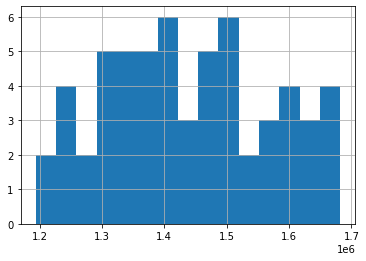

In [118]:
airport_profit_sorted_SVO.profit.hist(bins=15)
airport_profit_sorted_SVO.profit.describe()

На графике видно, что более и менее прибыльные рейсы распределены относительно нормально.

In [119]:
airport_profit_sorted_SVO.loc[(airport_profit_sorted_SVO['departure_day_of_week'].isin([0, 2, 6])) & (
    airport_profit_sorted_SVO['profit'] < airport_profit_sorted_SVO['profit'].quantile(0.25))].head(5)

,flight_id,arrival_airport,profit,ideal_profit,departure_day_of_week,actual_departure,departure_time,economy_percent,business_percent
54,136464,SVO,1193896.0,1.940307e+06,0,2017-01-09 10:07:00+00:00,10,78,58
21,136250,SVO,1201655.0,1.940307e+06,2,2017-02-08 10:06:00+00:00,10,77,66
2,136122,SVO,1226896.0,1.940307e+06,6,2017-01-08 10:08:00+00:00,10,73,83
12,136178,SVO,1232537.0,1.940307e+06,6,2017-01-29 10:10:00+00:00,10,76,75
38,136360,SVO,1251296.0,1.940307e+06,6,2017-02-05 10:08:00+00:00,10,72,91


Проведем такой же анализ для Белгорода. 

In [120]:
airport_profit_sorted_EGO.groupby('departure_day_of_week')[
    'economy_percent'].mean().sort_values(ascending=False)

departure_day_of_week
2    97.375000
5    93.625000
4    92.500000
1    92.222222
6    92.111111
3    91.500000
0    89.777778
Name: economy_percent, dtype: float64

In [121]:
airport_profit_sorted_EGO.groupby('departure_day_of_week')[
    'business_percent'].mean().sort_values(ascending=False)

departure_day_of_week
2    100.000000
5     93.500000
6     92.222222
0     91.555556
4     90.375000
3     89.500000
1     87.888889
Name: business_percent, dtype: float64

In [122]:
airport_profit_sorted_EGO.groupby(['departure_day_of_week'])[
    'profit'].mean().sort_values(ascending=False)

departure_day_of_week
2    686427.750000
5    650690.250000
6    640743.888889
4    639769.875000
3    632532.375000
1    631295.666667
0    627607.000000
Name: profit, dtype: float64

На рейсах в Белгород наибольшая загруженность в среду и в субботу как в общем, так и для бизнес-класса. Это же и самые прибыльные дни. А 

In [123]:
airport_profit_sorted_EGO.head(5)

,flight_id,arrival_airport,profit,ideal_profit,departure_day_of_week,actual_departure,departure_time,economy_percent,business_percent
93,136807,EGO,464274.0,820880.347222,3,2017-02-23 09:28:00+00:00,9,70,66
68,136642,EGO,465608.0,820880.347222,0,2017-01-30 09:28:00+00:00,9,63,83
100,136844,EGO,508374.0,820880.347222,1,2017-02-28 09:26:00+00:00,9,85,50
107,136887,EGO,529808.0,820880.347222,4,2017-01-20 09:30:00+00:00,9,82,66
111,136922,EGO,541074.0,820880.347222,5,2017-02-11 09:27:00+00:00,9,77,83


Гипотеза снова подтверждается. Рейс 136807 принес меньше всего прибыли и приходится на четверг - один из самых "слабых" дней недели для этого направления.


Однако поскольку данные в анализе не полные, необходимо провести дополнительное исследование. Для него мы выбрали 5 наименее прибыльных рейсов и проверили дополнительной выборкой, в которую попали рейсы, которые приходятся на наименее загруженные дни и прибыль от которых ниже нижнего квантиля. Для Белгорода эти списки совпадают на 80% (последняя позиция в списках разнится).

count        59.000000
mean     643596.288136
std       65685.099085
min      464274.000000
25%      599956.500000
50%      679674.000000
75%      697239.000000
max      699908.000000
Name: profit, dtype: float64

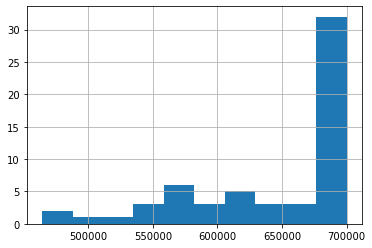

In [124]:
airport_profit_sorted_EGO.profit.hist(bins=10)
airport_profit_sorted_EGO.profit.describe()

In [125]:
airport_profit_sorted_EGO.loc[(airport_profit_sorted_EGO['departure_day_of_week'].isin([0, 1, 3, 4])) & (
    airport_profit_sorted_EGO['profit'] < airport_profit_sorted_EGO['profit'].quantile(0.25))].head(5)

,flight_id,arrival_airport,profit,ideal_profit,departure_day_of_week,actual_departure,departure_time,economy_percent,business_percent
93,136807,EGO,464274.0,820880.347222,3,2017-02-23 09:28:00+00:00,9,70,66
68,136642,EGO,465608.0,820880.347222,0,2017-01-30 09:28:00+00:00,9,63,83
100,136844,EGO,508374.0,820880.347222,1,2017-02-28 09:26:00+00:00,9,85,50
107,136887,EGO,529808.0,820880.347222,4,2017-01-20 09:30:00+00:00,9,82,66
65,136620,EGO,548108.0,820880.347222,4,2017-02-17 09:30:00+00:00,9,82,75


# Выводы

## Итерация 1

Кандидатами на вылет у нас становятся рейсы 136807 на Белгород и 136464 на Москву. Проверим их на относительную прибыль:

In [62]:
percent_profit_flight_msk = round(int(airport_profit[airport_profit.flight_id == 136464]['profit'] /ideal_profit_msk*100))

percent_profit_flight_blg = round(int(airport_profit[airport_profit.flight_id == 136807]['profit'] /ideal_profit_blg*100))

print('Относительная прибыль самого убыточного рейса на Москву приблизительно равна {}%, а на Белгород - {}%'.format(
    percent_profit_flight_msk, percent_profit_flight_blg))

Относительная прибыль самого убыточного рейса на Москву приблизительно равна 70%, а на Белгород - 66%


## Итерация 2

Все-таки самым убыточным признан рейс на Белгород под номером 136807. Он и является зоной повышенного риска для компании.

# Дополнительные исследования

В графиках была выдающаяся задержка рейса. Посмотрим на рейс, который так задержался

count    118.000000
mean       7.771186
std       29.560140
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max      207.000000
Name: delay, dtype: float64

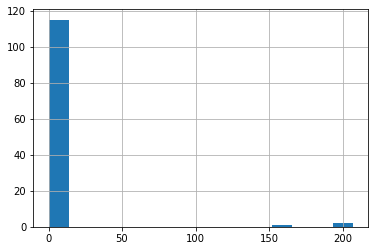

In [128]:
flight.delay.hist(bins=15)
flight.delay.describe()

In [129]:
flight.loc[flight['delay'] > flight['delay'].quantile(0.75)].sort_values(by = 'delay', ascending = False)[['flight_id', 'delay']].head(5)

,flight_id,delay
35,136345,207.0
67,136632,197.0
101,136855,162.0
117,136956,8.0
25,136269,8.0


Мы видим три рейса с аномальными значениями задержки. Хорошо бы для полноты картины узнать, что произошло, и выплачивали ли какие-то компенсации пассажирам этих рейсов.

# Аналитическая записка

## Затраты на рейс складываются из:

твердых затрат (не зависят от количества летных часов)
- повременная часть заработной платы экипажа;
- расходы на экипаж (форма, бортовое питание);
- стоянка самолета (взлет и посадка (аренда трапов, проезд по рулевым дорожкам), сверхнормативная стоянка, аренда стоек в аэропорту, использование терминалов и сервисов аэропорта)
- постоянные расходы на пассажиров (пледы-подушки, рекламно-сувенирная продукция)
- аэропортовые сборы (метеообеспечение, обеспечение авиационной безопасности)

операционных и эксплуатационных расходов (рассчитываются исходя из количества летных часов) 
- топливо; 
- спецжидкости, масла;
- техническое обслуживание самолета (плановое ТО, интенсивный ремонт); 
- сдельная часть зарплаты экипажа;
- аэронавигация;
- некоторые виды страхования;
- переменные расходы на пассажиров (питание (эконом, бизнес-класс, спецпитание, напитки), санитарно-гигиенические принадлежности) 

форс-мажоров

- срочный ремонт;
- компенсации за задержку рейсов;
- экстренная посадка.

Прочие расходы, в том числе административные, лизинговые, амортизационные, налоги, страховки


## Доходы от рейса складываются из:

- продажи билетов;
- платных услуг (сверхнормативный багаж, совместная рассадка)
- продажа напитков, дополнительного питания, сувениров

## Дополнительная экономия на рейсе:

- аренда дальних стоянок;
- использование автобуса вместо трапа.

## Прочее:

Пассажиры могут оплачивать часть стоимости билетов милями или другими бонусами


## Наиболее крупные группы затрат авиакомпаний непосредственно на рейс:

Топливо и прочие ГСМ: от 29 до 34%
Зарплата экипажа: 20%
Ремонт и ТО: 11%

## NB:
Отмена рейса должна сопровождаться перекидыванием воздушного судна на другое направление, так как простой самолета обходится ненамного дешевле, чем его эксплуатация (дополнительная парковка, ТО в период простоя, доставка самолета к месту парковки и так далее). Поэтому целесообразно одновременно провести анализ более перспективных направлений, на одно из которых можно перенаправить освободившийся борт.


## О текущем исследовании

В настоящем исследовании прибыль сведена к разности между стоимостью проданных билетов и стоимостью потраченного на полет топлива (от взлета до посадки - затраты на рулежные дорожки мы во внимание не принимаем).

Остальные доходы и затраты признаны по условиям задачи константами, которые на оценку прибыльности не влияют.

Для дополнительной глубины анализа введен параметр идеальной прибыли. По-хорошему ее надо бы рассчитывать для полностью загруженного самолета, вылетевшего и прилетевшего в точности по расписанию, однако более простой приблизительной оценкой будет средняя прибыль всех рейсов, заполненных на 100% (по направлениям).

Источники информации: https://bricsmagazine.com/ru/articles/ekonomika-poleta
https://www.airsoft-bit.ru/airport/124-polet-tasks
https://aviav.ru/kak-opredelyaetsya-tsena-bileta-na-samolet.html
https://studref.com/305952/ekonomika/metod_rascheta_sebestoimosti_aviaperevozok_opredeleniya_finansovogo_rezultata_summam_pokrytiya